In [881]:
import sys
import importlib
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad


In [882]:
sys.path.append('..')  # Go up one directory to where utils.py is located
import utils  # Ensure you import the module itself, not specific items
importlib.reload(utils)  # Reload the module to apply updates
from utils import *

Consider the simple harmonic oscillator $x:\mathbb{R}^+ \to \mathbb{R}$ given by:
$$ \begin{cases}
\frac{d^2x}{dt^2} &= -\omega^2 x \\
x(0) &= q_0 \\
\frac{dx}{dt}|_{t=0}& = p_0.
\end{cases},
$$
which can be reformulated as a system of differential equations
$$ 
\begin{cases}
\frac{dx}{dt} = y \\
\frac{dy}{dt} = -\omega^2 x  \\
x(0) = q_0 \\
y(0) = p_0,
\end{cases}
$$
where we defined $y:= \frac{dx}{dt}$. Our goal is to implement a simple DeepONet to approximate a solution for this BVP.

The analytical solution of the BVP is 
$$
\begin{cases}
x(t) = q_0 \cos(\omega t) + \frac{p_0}{\omega}\sin(\omega t)\\
y(t) = p_0 \cos(\omega t) - q_0 \omega \sin(\omega t).
\end{cases}
$$

In [883]:
# Get analytical solution of the BVP for given q0, p0 and t
def analytic_solution(bv, t, w=1):
    q0 = bv[:,None,0] 
    p0 = bv[:,None,1] 
    x = torch.tensor(q0 @ np.cos(w * t).T + (p0 @ np.sin(w * t).T) / w)
    y = torch.tensor(p0 @ np.cos(w * t).T - (q0 @ np.sin(w * t).T) * w)
    return torch.stack((x, y), dim=2)

In [884]:
def PI_loss_fn(u, t, w=1):

    x, y = u[...,0], u[...,1]
    
    ones = torch.ones_like(u[0,:,0])
    
    x_t = torch.stack([grad(xi.T, t, grad_outputs=ones, create_graph=True)[0].squeeze(-1) for xi in x])
    y_t = torch.stack([grad(yi.T, t, grad_outputs=ones, create_graph=True)[0].squeeze(-1) for yi in y])

    return torch.stack((x_t - y, y_t + (w**2)*x))    

In [885]:
T = 5
bv_ = np.random.uniform(low=-1, high=1, size=(3, 2)).astype(np.float32)
t = np.random.uniform(low=0, high=T, size=(10, 1)).astype(np.float32)
Px = (bv_, t)

In [886]:
bv = np.random.uniform(low=-1, high=1, size=(10, 2)).astype(np.float32)
t = np.random.uniform(low=0, high=T, size=(10, 1)).astype(np.float32)
y_train = analytic_solution(bv, t)
X_train = (bv, t)


In [887]:
bv = np.random.uniform(low=-1, high=1, size=(9, 2)).astype(np.float32)
t = np.random.uniform(low=0, high=T, size=(10, 1)).astype(np.float32)
y_test = analytic_solution(bv, t)
X_test = (bv, t)

In [888]:
net = DeepONet([2, 40, 40, 40], [1, 40, 40, 40], dim_out=2, activation='tanh')
model = Model(X_train, y_train, X_test, y_test, net, Px=None, PI_loss_fn=None, Tmax = 5)
model.train(iterations=10_001)

Step 	 Train loss 	 Test loss
1000 	 [4.77e-04] 	 [2.04e-03]
2000 	 [1.29e-04] 	 [1.90e-03]
3000 	 [7.75e-05] 	 [9.11e-04]
4000 	 [4.71e-05] 	 [5.05e-04]
5000 	 [2.73e-05] 	 [6.08e-04]
6000 	 [1.44e-04] 	 [1.14e-03]
7000 	 [3.21e-05] 	 [1.25e-03]
8000 	 [1.62e-03] 	 [2.78e-03]
9000 	 [2.52e-04] 	 [2.27e-03]
10000 	 [6.88e-06] 	 [2.33e-03]


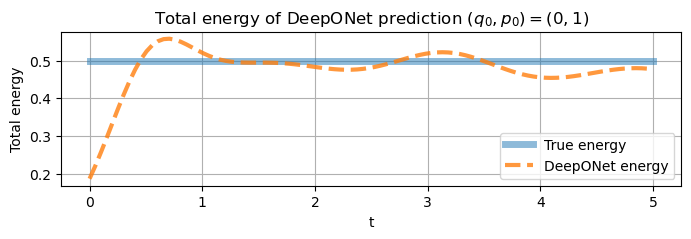

In [889]:
model.plot_energy()

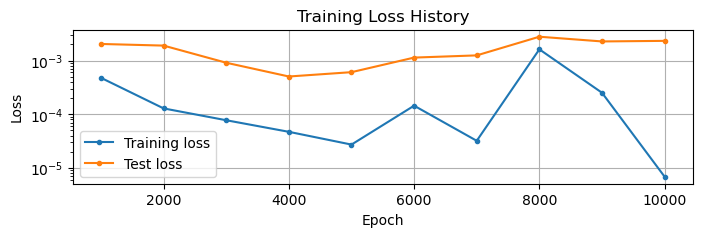

In [890]:
model.plot_losshistory()

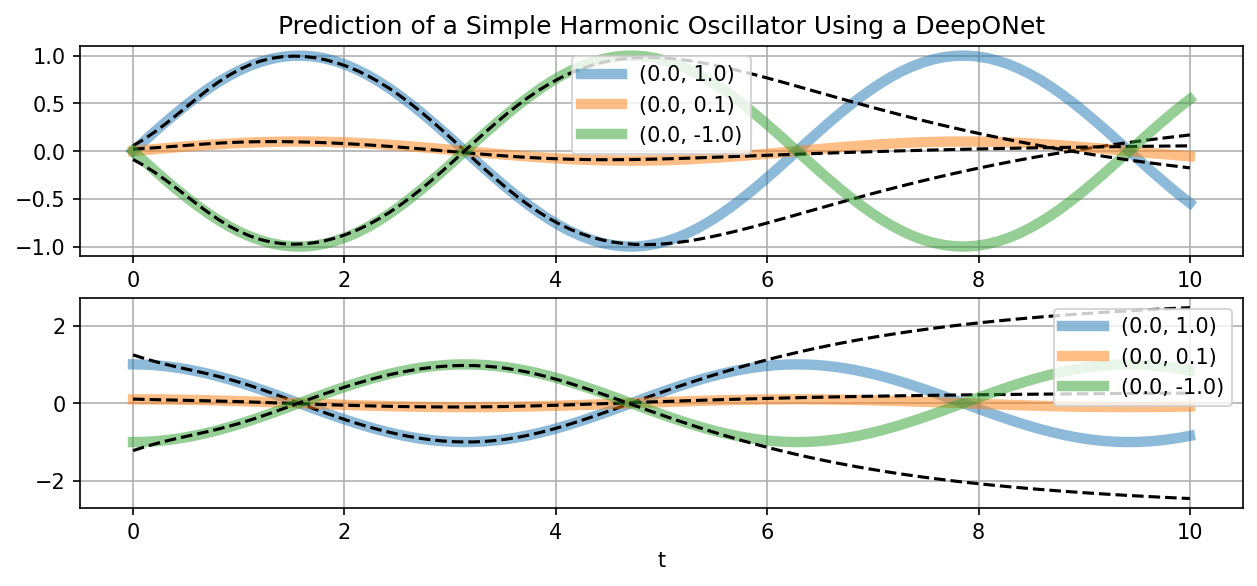

In [893]:
# Plot model prediction for one omega

# Get model prediction

t = np.linspace(0, 10, 100).reshape(-1, 1)
bv = np.array([[0, 1], [0, 0.1], [0,-1]]).astype(np.float32)

ground_truth = analytic_solution(bv, t)

pred = model.predict(bv, t)



# Plot prediction vs. solution
fig, axes = plt.subplots(2, 1, figsize=(10, 4), dpi=150)

axes[0].set_title('Prediction of a Simple Harmonic Oscillator Using a DeepONet')

for k, ax in enumerate(axes.flat):
    for l in range(pred.shape[0]):
        label = '({:.1f}, {:.1f})'.format(bv[l,0], bv[l,1])
        ax.plot(t.flatten(), ground_truth[l,:,k], label=label, alpha=0.5, linewidth=5)
        ax.plot(t.flatten(), pred[l,:,k].tolist(), '--', c='k')

    ax.legend()
    ax.grid(True)
ax.set_xlabel("t")
plt.show()